# Practical 03 - RRT Algorithm

Note: CoLab is not supported for this week. For the online version, please visit https://mybinder.org/v2/gh/tianleimin/ECE4078_Practical_2021/main and proceed as if running locally. **Remember to download a copy of the notebook when you are done if running online. Otherwise, you will lose the notebook once you close the tab.**

In [1]:
%matplotlib notebook

import math
import random
import os
import numpy as np
from IPython.display import display, HTML

# Import dependencies and set random seed
seed_value = 5
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)


from helper_james import *

global ani

[[1, 1], [0.7226964220743934, 0.8298221507852477], [0.3481785667960134, 0.9703083639083954], [0.022857115303880137, 0.7375725626249408], [-0.22360432898517685, 0.4225221595479855], [0.013527842139828022, 0.10039123365365052], [-0.179437260814427, -0.2499863755651091], [-0.5003580837908086, -0.4887536793991179], [-0.8786051456472457, -0.6188657856651105], [-1, -1]]


<IPython.core.display.Javascript object>


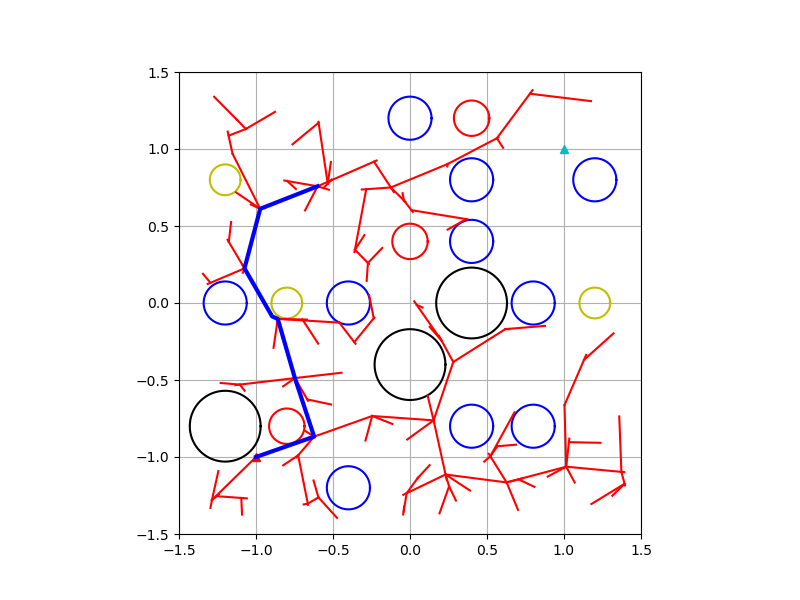

In [2]:
## build obstacle list from map file

gt_dict = {
    "lemon_2": {"y": 0.8, "x": -1.2}, 
    "lemon_1": {"y": 0.0, "x": -0.8}, 
    "lemon_0": {"y": 0.0, "x": 1.2}, 
    "aruco4_0": {"y": -0.8, "x": 0.8}, 
    "aruco3_0": {"y": 0.0, "x": 0.8}, 
    "aruco1_0": {"y": 0.0, "x": -1.2}, 
    "aruco8_0": {"y": -1.2, "x": -0.4}, 
    "apple_0": {"y": 1.2, "x": 0.4}, 
    "apple_1": {"y": -0.8, "x": -0.8}, 
    "aruco5_0": {"y": 0.8, "x": 0.4}, 
    "aruco9_0": {"y": 0.0, "x": -0.4}, 
    "apple_2": {"y": 0.4, "x": 0.0}, 
    "aruco6_0": {"y": -0.8, "x": 0.4}, 
    "person_2": {"y": -0.4, "x": 0.0}, 
    "person_0": {"y": -0.8, "x": -1.2}, 
    "person_1": {"y": 0.0, "x": 0.4}, 
    "aruco7_0": {"y": 1.2, "x": 0.0},
    "aruco10_0": {"y": 0.4, "x": 0.4}, 
    "aruco2_0": {"y": 0.8, "x": 1.2}
}
  
apple_gt, lemon_gt, person_gt, marker_gt = [], [], [], []

    # remove unique id of targets of the same type 
for key in gt_dict:
    if key.startswith('apple'):
        apple_id = key.split('_')[1]
        apple_gt.append(np.array([apple_id] + list(gt_dict[key].values()), dtype=float))
    elif key.startswith('lemon'):
        lemon_id = key.split('_')[1]
        lemon_gt.append(np.array([lemon_id] + list(gt_dict[key].values()), dtype=float))
    elif key.startswith('person'):
        person_id = key.split('_')[1]
        person_gt.append(np.array([person_id] + list(gt_dict[key].values()), dtype=float))
    elif key.startswith('aruco'):
        aruco_id = key.split('_')[0].split('aruco')[1]
        marker_gt.append(np.array([aruco_id] + list(gt_dict[key].values()), dtype=float))

r_true_apple = 0.075
r_true_lemon = 0.06
r_true_person = 0.19
r_true_marker = 0.1


scale = 0.04

r_true_apple += scale
r_true_lemon += scale
r_true_person += scale
r_true_marker += scale

all_obstacles = []
for entry in apple_gt:
    all_obstacles.append(CircleT(entry[2], entry[1], r_true_apple, 0))

for entry in lemon_gt:
    all_obstacles.append(CircleT(entry[2], entry[1], r_true_lemon, 1))
    
for entry in person_gt:
    all_obstacles.append(CircleT(entry[2], entry[1], r_true_person, 2))
    
for entry in marker_gt:
    all_obstacles.append(CircleT(entry[2], entry[1], r_true_marker, 3))


## obstacle list complete, we now want to generate pairings of people and apples, and mark which lemons need to be moved

required_distance = 0.5
goal_error = 0.05

## dont move apples that are already in place, find these pairs

people_done = []
apples_done = []
pairs = []


for person_idx, person in enumerate(person_gt):
    for apple_idx, apple in enumerate(apple_gt):
        if apple[0] in apples_done:
            continue
        elif np.hypot(apple[2] - person[2], apple[1] - person[1]) < (required_distance - goal_error):
            #if this is the case, an apple is within range of a person, including some consideration of error
            apples_done.append(apple[0])
            people_done.append(person[0])
            pairs.append((person, apple))
            
people_not_done = [n for n in person_gt if n[0] not in people_done]
apples_not_done = [n for n in apple_gt if n[0] not in apples_done]

#print(people_not_done, "\n", apples_not_done)

# assemble all combinations of people and apples who are not matched

unmatched_pairs = []
unmatched_person_ids = [n for n in person]

for person in people_not_done:
    for apple in apples_not_done:
        unmatched_pairs.append((person, apple, np.hypot(apple[2] - person[2], apple[1] - person[1])))

#print(unmatched_pairs)

# pick combination of unmatched pairs which minimises travel distance


list1 = ["a", "b", "c"]
list2 = [1, 2]

#all_combinations = [list(zip(each_permutation, list2)) for each_permutation in itertools.permutations(list1, len(list2))]





# run rrt pathing test
start = [-1, -1]
goal = [1, 1]

rrt = RRT(start=start, goal=goal, width=1.4, height=1.4, obstacle_list=all_obstacles, expand_dis=0.4, path_resolution=0.04)

print(rrt.planning())

ani_rrt = animate_path_rrt(rrt, (-1.5, 1.5), (-1.5, 1.5))
display(HTML("<style>.container { width:100% !important}</style>"))